# Assignment 2: Deep Learning for Image Classification
### Objectives of this assignment

In this assignment you will apply deep learning techniques for image classification.

Task 1: Data exploration and preparation using [Intel Image Classfication dataset on Kaggle](https://www.kaggle.com/datasets/puneet6060/intel-image-classification)

Task 2: Implement simple image classifiers and conduct an evaluation. 

Task 3: Implement Convolutional Network (ConvNet) and Pre-trained models (MobileNet) and conduct a more elaborate evaluation using confusion matrices from Keras datasets.

### Task 1 - Data exploration and preparation
#### 1.1 Exploration
1. Assign the list of available classes to a variable with name `CLASS_NAMES`. For each class name, display one image and print the dimensions of the corresponding numpy array.

In [1]:
import pandas as pd
import numpy as np
import keras
import keras_tuner as kt
import tensorflow as tf

In [2]:
import os

#List of classes
CLASS_NAMES = []
train_path = "data/seg_train/seg_train"
for folder in os.listdir(train_path):
    CLASS_NAMES.append(folder)
    
print("These are the available classes:", CLASS_NAMES)

These are the available classes: ['forest', 'buildings', 'glacier', 'street', 'mountain', 'sea']


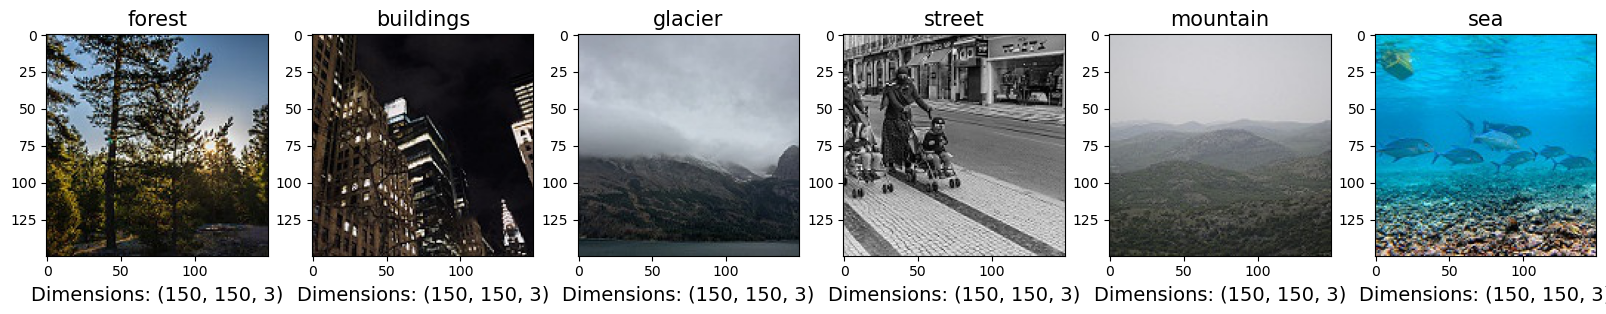

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

f, ax = plt.subplots(1, 6, figsize=(20,20))

idx = 0
for subdir, dirs, files in os.walk(train_path):
    for file in files:
        file_path = os.path.join(subdir, file)
        if (file_path.find("checkpoint") != -1):
            break

        # Display the image
        img = mpimg.imread(file_path)
        ax[idx].imshow(img);
        ax[idx].set_title(CLASS_NAMES[idx], fontsize = 15)
        ax[idx].set_xlabel((f"Dimensions: {img.shape}"), fontsize = 14)
        idx += 1
        break  # Stop after displaying the first PNG in the folder

2. Determine the number of images in the training and test sets for each class name. Are there any significant differences between the proportions of images in the training and test sets?

In [4]:
from collections import Counter

test_path = "data/seg_test/seg_test"

# Dictionary to hold the number of images in the training set for each class name 
train_image_counts = {}

for subdir, dirs, files in os.walk(train_path):
    image_count = 0
    
    for file in files:
        if (file.find("checkpoint") != -1):
            break
        else: image_count += 1
    
    if image_count > 0:
        folder_name = os.path.basename(subdir)
        train_image_counts[folder_name] = image_count

# Print the number of images in the training set for each class name 
for folder, count in train_image_counts.items():
    print(f"Training set has {count} samples of {folder} class.")

# Dictionary to hold the number of images in the test set for each class name 
test_image_counts = {}
print(f"\n")

for subdir, dirs, files in os.walk(test_path):
    image_count = 0
    
    for file in files:
        if (file.find("checkpoint") != -1):
            break
        else: image_count += 1
    
    if image_count > 0:
        folder_name = os.path.basename(subdir)
        test_image_counts[folder_name] = image_count

# Print the number of images in the test set for each class name 
for folder, count in test_image_counts.items():
    print(f"Test set has {count} samples of {folder} class.")

Training set has 2271 samples of forest class.
Training set has 2191 samples of buildings class.
Training set has 2404 samples of glacier class.
Training set has 2382 samples of street class.
Training set has 2512 samples of mountain class.
Training set has 2274 samples of sea class.


Test set has 474 samples of forest class.
Test set has 437 samples of buildings class.
Test set has 553 samples of glacier class.
Test set has 501 samples of street class.
Test set has 525 samples of mountain class.
Test set has 510 samples of sea class.


There is no significant differences between the proportions of images in the training and test sets. However, the data is not balanced either.

#### 1.2 Preparation
Use TensorFlow's `image_dataset_from_directory` to generate datasets for training, validation, and test. Make sure that you set the following options:

Image size: 
- 150 x 150 and 3 channels
- Colour mode = RGB
- Shuffle = True
- Seed = 1234
- Labels = inferred
- Class names = CLASS_NAMES
- Label mode = int or categorical (your choice)
- Batch size = 32. 

The other options can be left to their defaults.

1. To generate the training and validation set, use seg_train and specify a validation split of 0.2. (hint: use the options validation_split and subset).
2. To generate the test set, use seg_test.
Make sure that the image data are normalised between the values 0 and 1.

In [5]:
IMG_HEIGHT = 150
IMG_WIDTH = 150
IMG_CHANNELS = 3
BATCH_SIZE = 32

def process(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label

train_data, val_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    labels='inferred',
    label_mode='int',
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    shuffle=True,
    seed=1234,
    validation_split=0.2,
    subset='both'
)

train_data = train_data.map(process)
val_data = val_data.map(process)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    labels='inferred',
    label_mode='int',
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    shuffle=True,
    seed=1234
)

test_data = test_data.map(process)

Found 14036 files belonging to 6 classes.
Using 11229 files for training.
Using 2807 files for validation.
Found 3000 files belonging to 6 classes.


### Task 2 - A Simple Classifier 
#### 2.1 First classifier
Create a simple classifier that has the following layers:

- A Flatten layer.
- The output layer with the correct size and activation function for this classification task.  

Then, train the model with the training data. Use 20% of the training data to determine when to stop training. Finally, test the trained model on the test data and report the accuracy.

In [6]:
from keras.models import Sequential
from keras import layers
from keras.layers import Input, Flatten, Dense, Dropout
        
model = Sequential()
model.add(Input(shape=(IMG_HEIGHT, IMG_WIDTH,IMG_CHANNELS)))
model.add(Flatten())
model.add(layers.Dense(len(CLASS_NAMES), activation='softmax'))

model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 67500)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │       405,006 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 405,006 (1.54 MB)

 Trainable params: 405,006 (1.54 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
callbacks = [
    keras.callbacks.ModelCheckpoint("a2_simple_classifier.keras",
                                    save_best_only=True),
    keras.callbacks.EarlyStopping(patience=10)
]

history = model.fit(train_data,
                    epochs=20,
                    callbacks=callbacks,
                    batch_size=BATCH_SIZE,
                    validation_data=val_data)

Epoch 1/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.3416 - loss: 6.9774 - val_accuracy: 0.3413 - val_loss: 4.5301
Epoch 2/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.4227 - loss: 3.7598 - val_accuracy: 0.3905 - val_loss: 3.4248
Epoch 3/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.4683 - loss: 3.2591 - val_accuracy: 0.4247 - val_loss: 3.2742
Epoch 4/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.4662 - loss: 3.4424 - val_accuracy: 0.3028 - val_loss: 9.4475
Epoch 5/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.4888 - loss: 3.5257 - val_accuracy: 0.2978 - val_loss: 5.7006
Epoch 6/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.5065 - loss: 2.9921 - val_accuracy: 0.4197 - val_loss: 5.1673
Epoch 7/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.5322 - loss: 2.8282 - val_accuracy: 0.4670 - val_loss: 3.8437
Epoch 8/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.5531 - loss: 2.8442 - val_accu

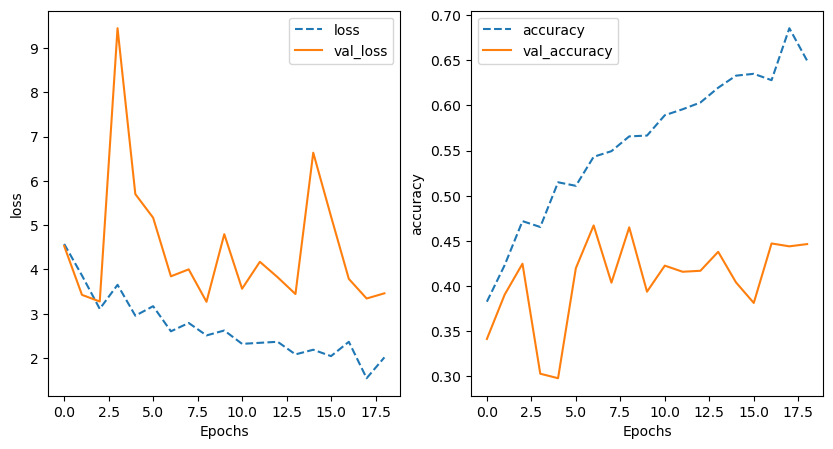

In [8]:
def training_plot(metrics, history):
    f, ax = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 5))
    for idx, metric in enumerate(metrics):
        ax[idx].plot(history.history[metric], ls='dashed')
        ax[idx].set_xlabel("Epochs")
        ax[idx].set_ylabel(metric)
        ax[idx].plot(history.history['val_' + metric]);
        ax[idx].legend([metric, 'val_' + metric])
        
training_plot(['loss', 'accuracy'], history)

In [9]:
model = keras.models.load_model("a2_simple_classifier.keras")
test_loss, test_acc = model.evaluate(test_data)
print('test_acc:', test_acc)

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4488 - loss: 3.3805
test_acc: 0.46399998664855957


#### 2.2 A more complex classifier
Try a more complex architecture that has 1 or more hidden layers with dropout. For this more complex architecture, use keras-tuner and run it with a reasonable choice of possible parameters. You may try among the following:

- Number of hidden layers
- Sizes of hidden layers
- Dropout rate
- Learning rate

In [10]:
def complex_classifier(rows, columns, channels, layer_options):
    network = Sequential()
    network.add(Input(shape=(rows, columns, channels)))
    network.add(Flatten())
    for i in range(len(layer_options)):
        network.add(Dense(layer_options[i][0], activation=layer_options[i][1]))
        if layer_options[i][2] > 0:
            network.add(Dropout(layer_options[i][2]))
    return network

def build_model(hp):
    num_hidden = hp.Int('num_hidden', 1, 5, 1) #number of hiiden layer
    hidden_size = hp.Int('hidden_size', 32, 256, 32) #hidden layer size
    activation = hp.Choice('activation', ['relu', 'sigmoid', 'tanh']) 
    dropout_rate = hp.Float('dropout', 0.0, 0.9, 0.1) #dropout rate 
    lrate = hp.Float('lrate', 1e-4, 1e-1, sampling='log')
    
    layers_options = []

    #create hidden layers
    for i in range(num_hidden):
        layers_options.append((hidden_size, activation, dropout_rate))
        
    model = complex_classifier(IMG_HEIGHT, IMG_WIDTH,IMG_CHANNELS, layers_options)
    model.add(layers.Dense(len(CLASS_NAMES), activation='softmax'))
        
    model.compile(optimizer=keras.optimizers.Adam(learning_rate = lrate),
                  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])
    return model
            

tuner = kt.BayesianOptimization(
    build_model,
    objective=kt.Objective('val_accuracy', 'max'),
    max_trials=10,
    num_initial_points=2,
    overwrite=True) #True to start afresh

tuner.search(
    train_data, validation_data=val_data,
    epochs=5,
    callbacks=[keras.callbacks.EarlyStopping(patience=5)]
)

topN = 1
for x in range(topN):
    print(tuner.get_best_hyperparameters(topN)[x].values)
    print(tuner.get_best_models(topN)[x].summary())

Trial 10 Complete [00h 03m 25s]
val_accuracy: 0.5097969174385071

Best val_accuracy So Far: 0.574634850025177
Total elapsed time: 00h 59m 28s
{'num_hidden': 4, 'hidden_size': 64, 'activation': 'relu', 'dropout': 0.0, 'lrate': 0.0001}


/Applications/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 67500)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     4,320,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,332,934 (16.53 MB)

 Trainable params: 4,332,934 (16.53 MB)

 Non-trainable params: 0 (0.00 B)

None


In [11]:
best_complex_model = tuner.get_best_models(num_models=1)
history = best_complex_model[0].fit(train_data,
                                    epochs=20,
                                    batch_size=BATCH_SIZE,
                                    validation_data=val_data,
                                    callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - accuracy: 0.5865 - loss: 1.1100 - val_accuracy: 0.5629 - val_loss: 1.1621
Epoch 2/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - accuracy: 0.6030 - loss: 1.0522 - val_accuracy: 0.5682 - val_loss: 1.1676
Epoch 3/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - accuracy: 0.6217 - loss: 1.0184 - val_accuracy: 0.5433 - val_loss: 1.2195
Epoch 4/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - accuracy: 0.6169 - loss: 1.0194 - val_accuracy: 0.5657 - val_loss: 1.1629
Epoch 5/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - accuracy: 0.6374 - loss: 0.9756 - val_accuracy: 0.5661 - val_loss: 1.1917
Epoch 6/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 13s 36ms/step - accuracy: 0.6482 - loss: 0.9528 - val_accuracy: 0.5693 - val_loss: 1.1722
Epoch 7/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.6511 - loss: 0.9252 - val_accuracy: 0.5768 - val_loss: 1.1469
Epoch 8/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 13s 36ms/step - accuracy: 0.6680 - loss: 0.8976 - 

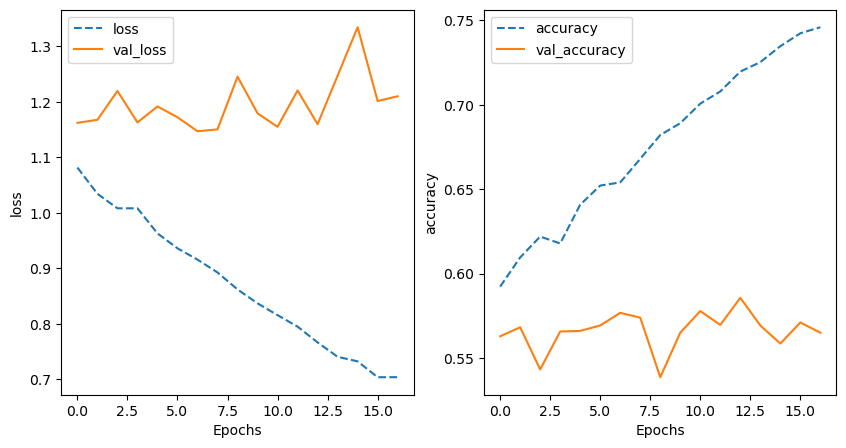

In [12]:
training_plot(['loss', 'accuracy'], history)

In [13]:
best_complex_model = tuner.get_best_models(num_models=1)
test_loss, test_acc = best_complex_model[0].evaluate(test_data)
print('Test accuracy:', test_acc)

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5496 - loss: 1.1907
Test accuracy: 0.5580000281333923


#### 2.3 Error analysis
Evaluate your best-performing system from task 2.2 against the system of task 2.1. In **separate text cells** of your Jupyter notebook, answer the following questions and justify the answer.

1. Which system had a better accuracy on the test data?
2. Which system had a lower degree of overfitting?

1. The **complex classifier perform better** on the test data. The simple classifier got 47.90% accuracy, meanwhile, the complex classifier got 49.07% accuracy.

2. The **complex classifier had a lower degree of overfitting**. Its training and validation loss curves show less disparity, and although the validation accuracy does not increase much, it is more stable compared to the simple classifier, where validation performance fluctuates wildly.

### Task 3 - A more complex classifier 
#### Task 3.1 Using ConvNets
Implement a model that uses a sequence of at least two `ConvD`, each one followed with `MaxPooling2D`. Use reasonable numbers for the hyperparameters (number of filters, kernel size, pool size, activation, etc), and justify your choice. Feel free to use the material from the lectures, and research the internet and / or generative AI to help you find a reasonable choice of hyperparameters. For this task, do not use pre-trained models.

In [14]:
conv_model = Sequential()
conv_model.add(layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)))
conv_model.add(layers.Conv2D(filters=32, kernel_size=3, activation="relu"))
conv_model.add(layers.MaxPooling2D(pool_size=2))
conv_model.add(layers.Conv2D(filters=64, kernel_size=3, activation="relu"))
conv_model.add(layers.MaxPooling2D(pool_size=2))
conv_model.add(layers.Conv2D(filters=128, kernel_size=3, activation="relu"))
conv_model.add(layers.MaxPooling2D(pool_size=2))
conv_model.add(layers.Flatten())
conv_model.add(layers.Dense(len(CLASS_NAMES), activation="softmax"))

conv_model.compile(optimizer='adam',
                   loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                   metrics=['accuracy'])

conv_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │       221,958 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 315,206 (1.20 MB)

 Trainable params: 315,206 (1.20 MB)

 Non-trainable params: 0 (0.00 B)

The parameters chosen and code below are based on the `Week 5` learning material. Since we are dealing with computationally heavy data, the first Conv2D layer uses 16 filters, and the second uses 32. The Dense layer combines all learned features from the first two layers and uses 6 filters for classification. The `ReLU` activation function is typically used for hidden layers, while the `softmax` activation function is typically used for output layers. The kernel size of `(3x3)` is also a standard choice for balancing model performance and efficiency. The added pooling layers help down-sample the feature maps, which will reduce the computational complexity of the model without disregarding important features.

I also used `GlobalAveragePooling2D()` instead of `Flatten()` because instead of converting the output from the last `Conv2D` layer into a large 1D vector with exponentially more parameters, it reduces the size of the feature map to a fixed-size vector (1 value per feature map channel). This will reduce the number of parameters which will prevent overfitting.

In [15]:
conv_callbacks = [
    keras.callbacks.ModelCheckpoint("a2_conv.keras",
                                    save_best_only=True),
    keras.callbacks.EarlyStopping(patience=5)
]

conv_history = conv_model.fit(train_data, validation_data=val_data, epochs=20,
                              callbacks=conv_callbacks)

Epoch 1/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 214s 608ms/step - accuracy: 0.5500 - loss: 1.1406 - val_accuracy: 0.7471 - val_loss: 0.7698
Epoch 2/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 211s 602ms/step - accuracy: 0.7514 - loss: 0.6922 - val_accuracy: 0.7909 - val_loss: 0.6151
Epoch 3/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 206s 588ms/step - accuracy: 0.8098 - loss: 0.5284 - val_accuracy: 0.7763 - val_loss: 0.6670
Epoch 4/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 207s 588ms/step - accuracy: 0.8543 - loss: 0.4061 - val_accuracy: 0.7859 - val_loss: 0.6336
Epoch 5/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 208s 591ms/step - accuracy: 0.8870 - loss: 0.3125 - val_accuracy: 0.8051 - val_loss: 0.6596
Epoch 6/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 204s 580ms/step - accuracy: 0.9270 - loss: 0.2106 - val_accuracy: 0.7820 - val_loss: 0.7836
Epoch 7/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 214s 611ms/step - accuracy: 0.9507 - loss: 0.1486 - val_accuracy: 0.7969 - val_loss: 0.8271


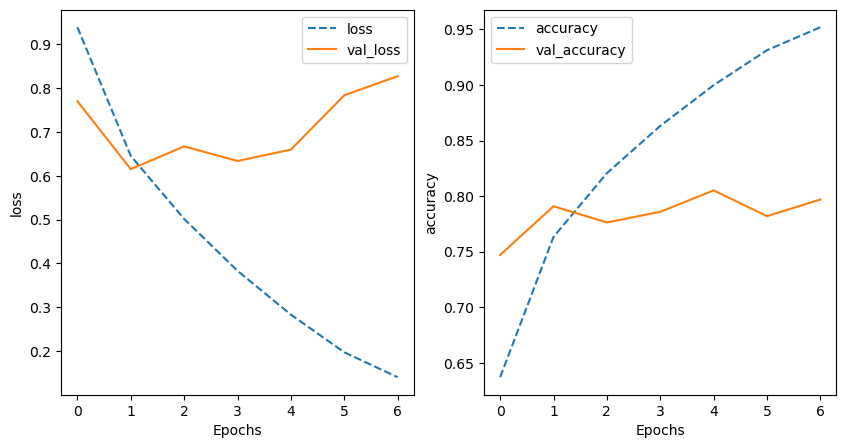

In [16]:
training_plot(['loss', 'accuracy'], conv_history)

In [17]:
conv_model = keras.models.load_model("a2_conv.keras")
test_loss, test_acc = conv_model.evaluate(test_data)
print('Test accuracy:', test_acc)

94/94 ━━━━━━━━━━━━━━━━━━━━ 15s 162ms/step - accuracy: 0.8127 - loss: 0.5582
Test accuracy: 0.7926666736602783


#### Task 3.2 Using pre-trained models
Use MobileNet, pre-trained on imagenet as discussed in the lectures. Add the correct classification layer, and train it with your data. Make sure that you freeze MobileNet's weights during training.

In [18]:
#Fetch the MobileNet model
mobilenet_model = tf.keras.applications.MobileNet(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), 
                                                  weights='imagenet',
                                                  include_top=False)

#Freeze weights
mobilenet_model.trainable = False

x=mobilenet_model.output
x=layers.GlobalAveragePooling2D()(x)
preds=Dense(len(CLASS_NAMES),activation='softmax')(x) #classification layer with softmax activation

pt_model=tf.keras.models.Model(inputs=mobilenet_model.input,outputs=preds)

# Compile the model
pt_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# Model summary
pt_model.summary()

/var/folders/0v/crjdqdx10_ldymfqj89t7tkc0000gn/T/ipykernel_8399/609529687.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet_model = tf.keras.applications.MobileNet(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),


Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 75, 75, 32)     │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 75, 75, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 75, 75, 32)     │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 75, 75, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 75, 75, 64)     │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 76, 76, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 37, 37, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 37, 37, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 37, 37, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 37, 37, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 37, 37, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 3,235,014 (12.34 MB)

 Trainable params: 6,150 (24.02 KB)

 Non-trainable params: 3,228,864 (12.32 MB)

Learning rate schedule: 1e-06 to 1e-06 to 1.53e-07


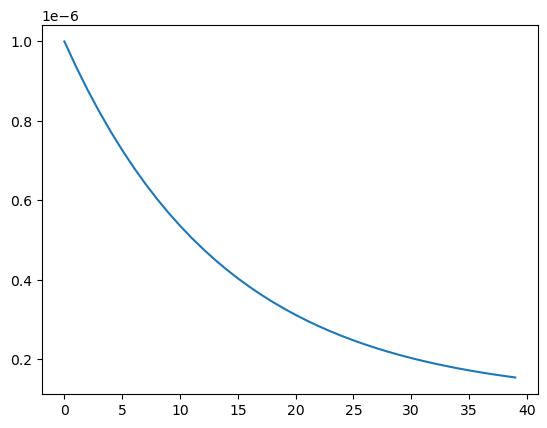

In [19]:
EPOCHS = 40

# Learning rate schedule
LR_START = 0.000001
LR_MAX = 0.000001
LR_MIN = 0.0000001
LR_RAMPUP_EPOCHS = 0
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = .93

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr

lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

In [20]:
class DelayedEarlyStopping(tf.keras.callbacks.EarlyStopping):
    def __init__(self, burn_in, **kwargs):
        super(DelayedEarlyStopping, self).__init__(**kwargs)
        self.burn_in = burn_in

    def on_epoch_end(self, epoch, logs=None):
        if epoch >= self.burn_in:
            super().on_epoch_end(epoch, logs)
        else:
            super().on_train_begin(logs=None)

In [21]:
pt_callbacks = [
    keras.callbacks.ModelCheckpoint("a2_pre_trained.keras",
                                    save_best_only=True),
    keras.callbacks.EarlyStopping(patience=5)
]

pt_history = pt_model.fit(train_data, validation_data=val_data, epochs=20,
                          callbacks=pt_callbacks)

Epoch 1/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 108s 305ms/step - accuracy: 0.7568 - loss: 0.6678 - val_accuracy: 0.8799 - val_loss: 0.3280
Epoch 2/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 128s 364ms/step - accuracy: 0.9083 - loss: 0.2533 - val_accuracy: 0.8896 - val_loss: 0.3056
Epoch 3/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 109s 311ms/step - accuracy: 0.9231 - loss: 0.2126 - val_accuracy: 0.8864 - val_loss: 0.3207
Epoch 4/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 107s 306ms/step - accuracy: 0.9312 - loss: 0.1905 - val_accuracy: 0.8953 - val_loss: 0.3016
Epoch 5/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 107s 306ms/step - accuracy: 0.9397 - loss: 0.1654 - val_accuracy: 0.8935 - val_loss: 0.3189
Epoch 6/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 108s 308ms/step - accuracy: 0.9447 - loss: 0.1575 - val_accuracy: 0.8945 - val_loss: 0.3265
Epoch 7/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 106s 303ms/step - accuracy: 0.9504 - loss: 0.1415 - val_accuracy: 0.8846 - val_loss: 0.3490
Epoch 8/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 108s 309ms/step - accuracy: 0.9519 -

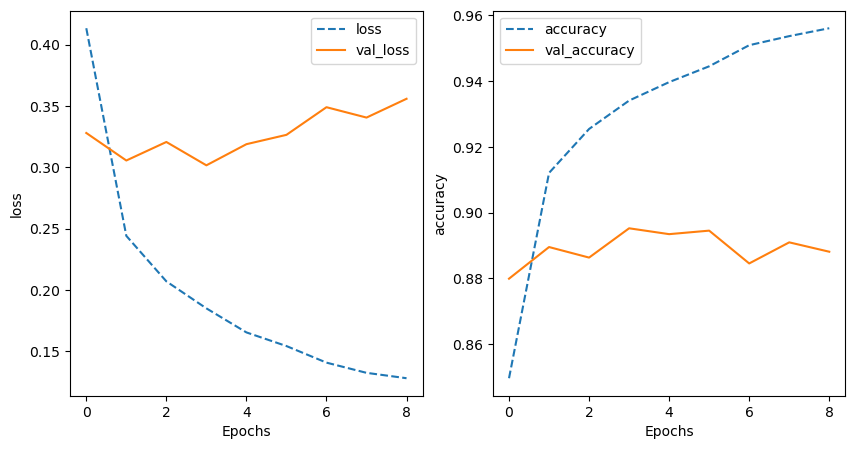

In [22]:
training_plot(['loss', 'accuracy'], pt_history)

In [23]:
pt_model = keras.models.load_model("a2_pre_trained.keras")
test_loss, test_acc = pt_model.evaluate(test_data)
print('Test accuracy:', test_acc)

94/94 ━━━━━━━━━━━━━━━━━━━━ 27s 279ms/step - accuracy: 0.9031 - loss: 0.2590
Test accuracy: 0.8999999761581421


#### Task 3.3 Comparative evaluation 
Compare the evaluation results of the best systems from tasks 3.1 and 3.2 and answer the following questions.

1. Display the confusion matrix generated by the best system on the test set. For this you can use, for example, TensorFlow's confusion_matrix.

2. Identify the most commont type of classification error reported by the confusion matrix, and display 5 images from the test set that have this classification error.

Note that `image_dataset_from_directory` shuffles the samples each time you complete an epoch. You need to figure out how to retrieve the data, labels, and generate predictions, without saving the entire data in memory.

**1. Confusion Matrix**

In [24]:
import seaborn as sns

true_labels = np.concatenate([y for x, y in test_data], axis=0)
predictions = model.predict(test_data)
predicted_labels = np.argmax(predictions, axis=1)

25/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

2025-11-29 13:29:58.159083: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


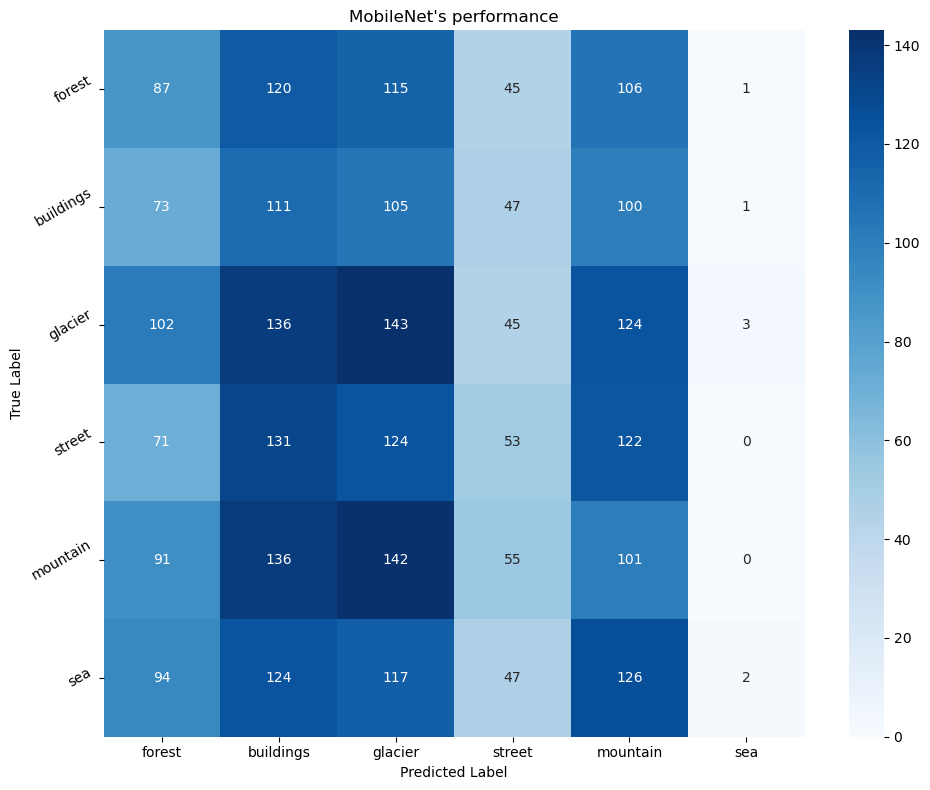

In [25]:
cm = tf.math.confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.title("MobileNet's performance")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.yticks(rotation=30)
plt.tight_layout()
plt.show()

Based on the confusion matrix generated, it is evident that:

**Correct Predictions**
- The highest correct classifications are within the `sea` class with 146 correct predictions.
- The lowest correct classifications are within the `buildings` class with only 35 correct predictions.

**Misclassifications**
  - The highest misclassified situation is `sea` -> `glacier`, with 185 `sea` images are misclassified as `glacier`. This could be due to the fact that they have overlapping, more complex visual textures, colors, and environmental elements that the model struggles to understand.

**2. Misclassified Images**

In [26]:
true_class = CLASS_NAMES.index('sea')
predicted_class = CLASS_NAMES.index('glacier')

misclassified_indices = np.where((true_labels == true_class) & (predicted_labels == predicted_class))[0]

In [27]:
misclassified_images = []
misclassified_true_labels = []
misclassified_predicted_labels = []

In [28]:
for i, (img_batch, label_batch) in enumerate(test_data):
    batch_size = len(img_batch)

    # Since the model predicts on the whole test set at once and does not separate predictions by batch, I will need to manually slice the labels by batch
    # In this case, I am using the index number multiplied to the batch size to get the start index of the range of labels and the current batch index multiplied to the batch size to get the end index of the labels
    start_index = i * batch_size
    end_index = (i + 1) * batch_size
    predicted_labels_batch = predicted_labels[start_index:end_index]


    # Next, I will need to loop over the current batch of images, predicted labels, and true labels
    # I will be using zip() to loop over the three lists at the same time to return one img, its true_label, and its predicted_label
    for img, true_label, predicted_label in zip(img_batch, label_batch, predicted_labels_batch):
        if len(misclassified_images) >= 5:  # This will make the loop stop iterating after 5 misclassified images are stored
            break

        # Next, I will need to check if the true label of an image is 'glacier' and its predicted label is 'forest'
        if true_label == CLASS_NAMES.index('sea') and predicted_label == CLASS_NAMES.index('glacier'):
            misclassified_images.append(img.numpy())  # When the condition is true, it converts the img tensor into a NumPy Array so that it can be passed onto the matplotlib function plt.imshow()
            misclassified_true_labels.append(true_label)  # I will also append the true label to the misclassified_true_labels array
            misclassified_predicted_labels.append(predicted_label)  # I will also append the predicted label to the misclassified_predicted_labels array

    if len(misclassified_images) >= 5:
        break  # When misclassified images are at the count of 5, the loop will stop

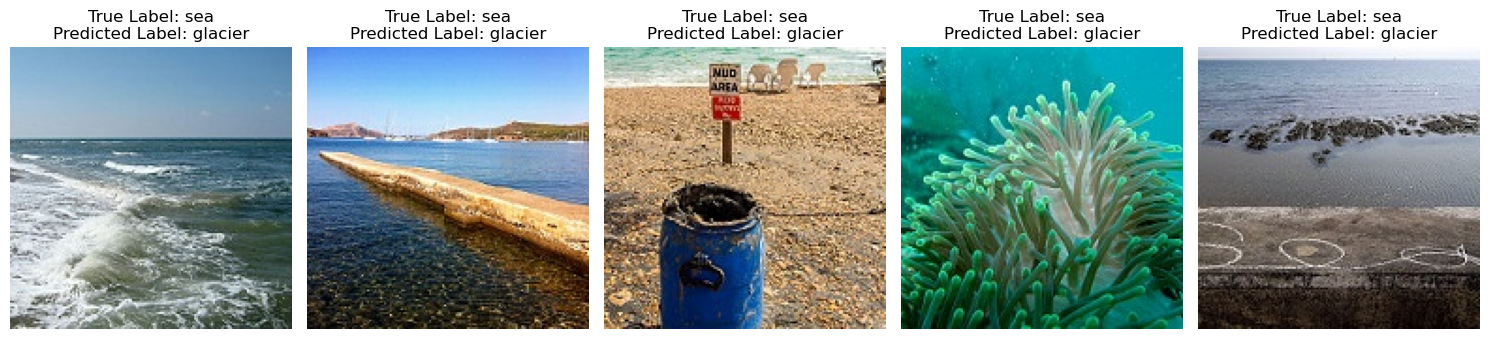

In [29]:
plt.figure(figsize=(15, 5))  

for i in range(len(misclassified_images)): 
        true_label_name = CLASS_NAMES[int(misclassified_true_labels[i])]
        predicted_label_name = CLASS_NAMES[int(misclassified_predicted_labels[i])]

        plt.subplot(1, 5, i + 1)
        plt.imshow(misclassified_images[i])
        plt.title(f"True Label: {true_label_name}\nPredicted Label: {predicted_label_name}")
        plt.axis('off')

plt.tight_layout()
plt.show()